In [1]:
# all of the setup from the intro.ipynb + more
# remember to run this cell every time you start a new session
# for others looking at this code, read the comments to perhaps better understand things

# io.py was updated to get objectId
from snowshovel.io import read_single_alert, parse_alerts
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set this to the directory containing the unzipped avro alerts
data_dir = Path("C:/Users/natha/Downloads/ztf_public_20230609/")

# once new sets are saved to the directory, you can skip the next 11 cells that led to the creation of the new sets 

In [2]:
#this takes the longest actually
pd.set_option('display.max_columns', None)
## Set the number of alerts to read (total number is 71708 oh god)
n_to_read = 71708
alerts_df = parse_alerts(data_dir=data_dir, n_to_read=n_to_read)

#(to print it if needed)
alerts_df

100%|██████████████████████████████████████████████████████████████████████████| 71708/71708 [1:05:40<00:00, 18.20it/s]


,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,nid,rcid,field,xpos,ypos,ra,dec,magpsf,sigmapsf,chipsf,magap,sigmagap,distnr,magnr,sigmagnr,chinr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,magfromlim,seeratio,aimage,bimage,aimagerat,bimagerat,elong,nneg,nbad,rb,ssdistnr,ssmagnr,ssnamenr,sumrat,magapbig,sigmagapbig,ranr,decnr,sgmag1,srmag1,simag1,szmag1,sgscore1,distpsnr1,ndethist,ncovhist,jdstarthist,jdendhist,scorr,tooflag,objectidps1,objectidps2,sgmag2,srmag2,simag2,szmag2,sgscore2,distpsnr2,objectidps3,sgmag3,srmag3,simag3,szmag3,sgscore3,distpsnr3,nmtchps,rfid,jdstartref,jdendref,nframesref,rbversion,dsnrms,ssnrms,dsdiff,magzpsci,magzpsciunc,magzpscirms,nmatches,clrcoeff,clrcounc,zpclrcov,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion,objectId
0,2.46010e+06,1,2350249170015,20.19678,ztf_20230609249155_000326_zg_c01_o_q1_scimrefd...,Kulkarni,1,2350249170015010010,f,10,2350,0,326,1293.81946,841.44751,230.91488,-19.23859,17.37607,0.04735,14.49042,17.4033,0.0327,0.16106,15.559,0.013,0.605,-0.018,0.57784,0.02723,2.97000,0.995,841.44751,2.79348,0.93690,0.806,0.733,0.27138,0.24680,1.09959,7,0,0.84286,-999.0,-999.0,null,0.96234,17.3836,0.0384,230.91492,-19.23862,15.5261,15.3925,15.2156,15.3263,0.99292,0.22768,620,1157,2.45825e+06,2.46010e+06,25.12418,0,84912309149143984,84912309147549191,21.1468,20.7159,20.6688,20.6064,0.92408,15.49902,84912309100695701,-999.0000,22.0089,21.3328,20.9840,0.68470,16.99300,7,326120100,2.45820e+06,2.45834e+06,15,t17_f5_c3,46.75406,116.18320,-69.42914,26.11907,3.44710e-06,0.03100,1914,-0.05895,7.64290e-06,-4.82000e-06,26.086,0.554,0.23040,0.22827,-999.00000,15.31550,-999.00000,30.0,0.99997,d6_m7,ZTF18adbairy
1,2.46010e+06,1,2350249170015,20.19678,ztf_20230609249155_000326_zg_c01_o_q1_scimrefd...,Kulkarni,1,2350249170015010011,f,11,2350,0,326,2251.54736,952.32709,230.63009,-19.27357,17.23907,0.07838,15.63444,17.1618,0.0302,0.17330,14.819,0.014,0.693,-0.031,-0.45475,-0.07727,1.39130,0.997,820.95270,3.03498,2.00000,0.918,0.831,0.65981,0.59728,1.10469,4,0,0.86714,-999.0,-999.0,null,0.98856,17.1628,0.0348,230.63008,-19.27352,14.7415,14.5397,14.4478,14.5440,0.99937,0.06008,639,1157,2.45825e+06,2.46010e+06,8.28832,0,84872306301102099,84862306319218721,17.4145,16.1386,15.4337,15.0987,0.99542,11.84914,84862306324017765,-999.0000,-999.0000,-999.0000,19.8708,0.50000,15.27060,10,326120100,2.45820e+06,2.45834e+06,15,t17_f5_c3,47.92783,122.22408,-74.29626,26.11907,3.44710e-06,0.03100,1914,-0.05895,7.64290e-06,-4.82000e-06,26.086,0.554,0.23040,0.06621,-999.00000,14.55626,-999.00000,30.0,0.99925,d6_m7,ZTF18adbairx
2,2.46010e+06,1,2350249170015,20.19678,ztf_20230609249155_000326_zg_c01_o_q1_scimrefd...,Kulkarni,1,2350249170015010013,f,13,2350,0,326,963.04303,1001.52472,231.01415,-19.28220,18.31207,0.06123,4.67239,18.2801,0.0639,0.13447,16.889,0.013,0.344,-0.029,-0.84160,-0.03197,2.57000,0.983,963.04303,1.91668,1.08273,0.796,0.756,0.30973,0.29416,1.05291,1,0,0.93857,-999.0,-999.0,null,1.00000,18.2587,0.0784,231.01419,-19.28221,17.3366,16.9872,16.5080,16.7554,0.98275,0.16924,611,1157,2.45824e+06,2.46010e+06,17.37244,0,84862310141941644,84862310105732305,21.1030,20.4647,19.9157,19.7564,0.05110,12.30542,84862310091721618,20.4324,19.5096,18.8407,18.5643,0.01329,16.96577,12,326120100,2.45820e+06,2.45834e+06,15,t17_f5_c3,26.27319,50.40653,-24.13334,26.11907,3.44710e-06,0.03100,1914,-0.05895,7.64290e-06,-4.82000e-06,26.086,0.554,0.23040,0.17549,-999.00000,16.76741,-999.00000,30.0,1.00000,d6_m7,ZTF18adbinmg
3,2.46010e+06,1,2350249170015,20.19678,ztf_20230609249155_000326_zg_c01_o_q1_scimrefd...,Kulkarni,1,2350249170015010023,f,23,2350,0,326,1323.92407,1718.97986,230.90993,-19.48553,18.98307,0.08573,1.16015,19.0281,0.1258,0.42402,17.130,0.015,0.693,-0.030,0.08534,0.04503,1.39130,0.764,1323.92407,1.16868,2.00000,0.756,0.706,0.54338,0.50744,1.07082,3,0,0.93286,-999.0,-999.0,null,0.99229,19.0099,0.1556,230.90988,-19.48542,16.9815,16.3647,16.1259,16.0876,1.

In [3]:
# adjusted for useful information
useful_columns = [
    #"isdiffpos", # Is the detection postive (more flux in science image than reference), or negative (less flux)?
    "ra", # What is the sky position in Right Ascension?
    "dec", # What is the sky position in Declination?
    "objectId", # the object ID
    "candid", # candidate ID (?)
    #"magpsf", # What is the magnitude (brightness) of the detection?
    #"sigmapsf", # What is the uncertainty on the magnitude?
    #"distnr", # How close is the detection to a known source in the reference image?
    "ndethist", # How many times has this object been detected?
]

slim_alerts_df = alerts_df[useful_columns]

# Bad subtractions are often not repeated
# Let's restrict ourselves to sources which are detected at least twice
mask = slim_alerts_df["ndethist"] > 1
slim_alerts_df = slim_alerts_df[mask].reset_index()
print(f"There are {len(slim_alerts_df)} alerts passing our cut")
slim_alerts_df

There are 42178 alerts passing our cut


,index,ra,dec,objectId,candid,ndethist
0,0,230.91488,-19.23859,ZTF18adbairy,2350249170015010010,620
1,1,230.63009,-19.27357,ZTF18adbairx,2350249170015010011,639
2,2,231.01415,-19.28220,ZTF18adbinmg,2350249170015010013,611
3,3,230.90993,-19.48553,ZTF18adbaidy,2350249170015010023,721
4,4,230.43507,-19.49976,ZTF21aalkhuz,2350249170015010024,65
...,...,...,...,...,...,...
42173,71700,305.73211,35.63610,ZTF18aazmjpp,2350383655915015023,898
42174,71701,305.73216,35.63609,ZTF18aazmjpp,2350383655915015024,895
42175,71702,305.81875,35.67036,ZTF18aawcdaq,2350383655915015026,1336
42176,71705,305.89926,35.57294,ZTF18aaxpmln,2350383655915015032,942


In [4]:
# saving results to read the same data quicker if necessary
name = "slim_alerts_df.csv"
slim_alerts_df.to_csv(name, index=False)

In [3]:
# if necessary, run this code to not have to wait 1 hour to read the whole ztf set to get to the slim_alerts_df
slim_alerts_df = pd.read_csv('slim_alerts_df.csv')
slim_alerts_df

,index,ra,dec,objectId,candid,ndethist
0,0,230.914883,-19.238593,ZTF18adbairy,2350249170015010010,620
1,1,230.630090,-19.273569,ZTF18adbairx,2350249170015010011,639
2,2,231.014147,-19.282204,ZTF18adbinmg,2350249170015010013,611
3,3,230.909926,-19.485533,ZTF18adbaidy,2350249170015010023,721
4,4,230.435069,-19.499763,ZTF21aalkhuz,2350249170015010024,65
...,...,...,...,...,...,...
42173,71700,305.732106,35.636097,ZTF18aazmjpp,2350383655915015023,898
42174,71701,305.732159,35.636089,ZTF18aazmjpp,2350383655915015024,895
42175,71702,305.818751,35.670357,ZTF18aawcdaq,2350383655915015026,1336
42176,71705,305.899257,35.572941,ZTF18aaxpmln,2350383655915015032,942


In [5]:
# reading the variable star catalogue data
# skiprows because of how the data is given, of which rows 0 through 8 are not data
# total is 432237; utilize the code: ", (10001, 432237)" after "(0,8)" for limiting range to 10000 if needed
skip_ranges = [(0, 8)]
skip_rows = [i for start, end in skip_ranges for i in range(start, end)]
variable_star = pd.read_csv('results6_22_18_27_3827.csv', skiprows=skip_rows)
variable_star

,# vivaID,ra,dec,aVar,bestPeriod
0,515403326727,270.43506,-19.51723,0.13434,0.39252
1,515403270290,270.36061,-19.59807,0.58929,0.03669
2,515403212626,270.68938,-19.90698,0.47464,0.81980
3,515403187805,270.81500,-20.02975,0.55140,0.03760
4,515403141120,270.27365,-19.84197,0.30284,0.84415
...,...,...,...,...,...
432231,515937080067,193.94203,-64.64124,0.36487,0.42431
432232,515937099278,193.99323,-64.27704,0.29054,0.38401
432233,515937113364,194.03036,-64.33027,0.30155,0.03560
432234,515937123034,194.08149,-64.44958,0.42763,8.32291


In [2]:
# merely testing
#def make_bins(n_bins):
#    decs = np.linspace(-90., 90., n_bins+1)
#    for i, lower_dec in enumerate(decs[:-1]):
#        upper_dec = decs[i+1]
#        print(i, lower_dec, upper_dec)
#make_bins(18)

In [7]:
# define the columns of the original dataframe (slim_alerts_df) to be used in the shortened ones
columns = ["ra", "dec", "objectId", "candid", "ndethist"]

# define the new bins for the "dec" column

# the bin_num, range of 1, and -1 in the code works but is bad coding practice; adjust later maybe
bin_num = 37
dec_bins = np.linspace(-90., 90., bin_num)  # 36 bins (1 less than bin_num); each bin with range of 5 degrees

# create a dictionary to store the dataframes for each set, columns in dataframe based on what was defined earlier
slim_sets = {f'slim_set{i}': pd.DataFrame(columns=columns) for i in range(1, bin_num)}

# total number of rows in slim_alerts_df for tqdm
total_rows = len(slim_alerts_df)

# iterate over each row in "slim_alerts_df"
for _, row in tqdm(slim_alerts_df.iterrows(), total=total_rows, desc='making new dataframes for slim_alerts_df'):
    # get the value of the "dec" column on the corresponding row
    dec_value = row["dec"]
    
    # find the bin index where the dec_value falls into
    bin_index = np.digitize(dec_value, dec_bins) - 1
    
    # add the row to the respective set dataframe
    slim_sets[f'slim_set{bin_index}'].loc[len(slim_sets[f'slim_set{bin_index}'])] = row

# the "slim_sets" dictionary will contain the filtered dataframes for each set. 

# printing to see
for set_name, set_df in slim_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()

making new dataframes for slim_alerts_df: 100%|█████████████████████████████████| 42178/42178 [00:47<00:00, 888.83it/s]

Set Name: slim_set1
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set2
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set3
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set4
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set5
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set6
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set7
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set8
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set9
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set10
Empty DataFrame
Columns: [ra, dec, objectId, candid, ndethist]
Index: []

Set Name: slim_set11
           ra       dec      objectId 

In [8]:
# same thing for the other other dataframe    
# define the columns of the original dataframe (variable_star) to be used in the shortened ones
columns = ["# vivaID","ra","dec","aVar","bestPeriod"]
dec_bins = np.linspace(-90., 90., bin_num) 
var_star_sets = {f'var_star_set{i}': pd.DataFrame(columns=columns) for i in range(1, bin_num)}
total_rows = len(variable_star)

for _, row in tqdm(variable_star.iterrows(), total=total_rows, desc='Processing variable_star rows'):
    dec_value = row["dec"]
    bin_index = np.digitize(dec_value, dec_bins) - 1
    var_star_sets[f'var_star_set{bin_index}'].loc[len(var_star_sets[f'var_star_set{bin_index}'])] = row

for set_name, set_df in var_star_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()

Processing variable_star rows: 100%|██████████████████████████████████████████| 432236/432236 [09:08<00:00, 788.49it/s]

Set Name: var_star_set1
Empty DataFrame
Columns: [# vivaID, ra, dec, aVar, bestPeriod]
Index: []

Set Name: var_star_set2
Empty DataFrame
Columns: [# vivaID, ra, dec, aVar, bestPeriod]
Index: []

Set Name: var_star_set3
Empty DataFrame
Columns: [# vivaID, ra, dec, aVar, bestPeriod]
Index: []

Set Name: var_star_set4
       # vivaID         ra       dec     aVar  bestPeriod
0   5.15936e+11  191.68773 -65.01010  0.39028     0.04523
1   5.15935e+11  195.43457 -65.00406  0.16259     2.61416
2   5.15936e+11  190.72193 -65.00429  0.37773     0.06587
3   5.15937e+11  192.84108 -65.03618  0.39342    10.14998
4   5.15937e+11  193.25003 -65.00868  0.49779     0.27047
5   5.15936e+11  190.66214 -65.03791  0.36886     0.05641
6   5.15937e+11  193.07849 -65.01388  0.37238     0.14422
7   5.15935e+11  195.42584 -65.07684  0.35140     0.33178
8   5.15935e+11  195.42859 -65.07964  0.12976     4.72339
9   5.15936e+11  191.51782 -65.03008  0.46414     0.14548
10  5.15936e+11  191.51382 -65.08000  0.5098

In [22]:
# meant to check after adding the "Coordinate" column, probably no longer needed really
# useful for more easily comparing and seeing which data sets actually pair; above cell look for variable star set (number)
# this cell look for slim set (number)

#prints both dictionaries and its sets
for set_name, set_df in slim_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()
    
for set_name, set_df in var_star_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()

Set Name: slim_set1
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set2
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set3
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set4
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set5
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set6
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set7
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set8
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []



       # vivaID         ra       dec     aVar  bestPeriod  \
0   5.15936e+11  191.68773 -65.01010  0.39028     0.04523   
1   5.15935e+11  195.43457 -65.00406  0.16259     2.61416   
2   5.15936e+11  190.72193 -65.00429  0.37773     0.06587   
3   5.15937e+11  192.84108 -65.03618  0.39342    10.14998   
4   5.15937e+11  193.25003 -65.00868  0.49779     0.27047   
5   5.15936e+11  190.66214 -65.03791  0.36886     0.05641   
6   5.15937e+11  193.07849 -65.01388  0.37238     0.14422   
7   5.15935e+11  195.42584 -65.07684  0.35140     0.33178   
8   5.15935e+11  195.42859 -65.07964  0.12976     4.72339   
9   5.15936e+11  191.51782 -65.03008  0.46414     0.14548   
10  5.15936e+11  191.51382 -65.08000  0.50985     0.05313   
11  5.15936e+11  191.56332 -65.01186  0.89132     0.33307   
12  5.15934e+11  194.27584 -65.01283  0.20040     4.94568   
13  5.15937e+11  194.07582 -65.00819  0.31071     1.68733   
14  5.15935e+11  196.29254 -65.05518  0.36140     0.73779   
15  5.15937e+11  193.116

In [9]:
# loop through each set and save each new slim set as a CSV file in the directory for easy access
for set_name, slim_set in slim_sets.items():
    filename = f"{set_name}.csv"  # Name the CSV file based on the set_name
    slim_set.to_csv(filename, index=False)  # Save the DataFrame as CSV without the index column

In [ ]:
# do the same for each new variable star set
for set_name, var_star_set in var_star_sets.items():
    filename = f"{set_name}.csv"  # Name the CSV file based on the set_name
    var_star_set.to_csv(filename, index=False)  # Save the DataFrame as CSV without the index column

In [13]:
# continue from here after the downloading of packages if there are sets saved in the directory

# read all of the new saved csv files, putting it back into dictionaries since that is what I used earlier 
# (so I don't have to adjust the later code)

slim_sets = {}
var_star_sets = {}
set_num = 1
total_set_num = 36
while set_num <= total_set_num:
    slim_filename = f"slim_set{set_num}.csv"
    slim_sets[f'slim_set{set_num}'] = pd.read_csv(slim_filename)
    
    var_filename = f"var_star_set{set_num}.csv"
    var_star_sets[f'var_star_set{set_num}'] = pd.read_csv(var_filename)
    
    set_num += 1

In [14]:
# have to do this again after reading the bin/set files, probably due the "Coordinate" column not being saved as the... 
# proper data type; it probably made it into a string/object instead of what it is supposed to be 

# loop through each slim_set, create a coordinate and put value into new "Coordinate" column (for comparisons later)
for set_name, slim_set in tqdm(slim_sets.items(), desc='Processing slim_sets'):
    # update the 'Coordinate' column for the current slim_set
    slim_set["Coordinate"] = SkyCoord(slim_set["ra"], slim_set["dec"], frame='icrs', unit='deg')

# do the same for var_star_set
for set_name, var_star_set in tqdm(var_star_sets.items(), desc='Processing var_star_set'):
    # Update the 'Coordinate' column for the current var_star_set
    var_star_set["Coordinate"] = SkyCoord(var_star_set["ra"], var_star_set["dec"], frame='icrs', unit='deg')

Processing var_star_set: 100%|█████████████████████████████████████████████████████████| 36/36 [00:56<00:00,  1.57s/it]


In [33]:
# create a list to store the results
results = []

# the set that is being compared
set_num = 13

# get the total number of iterations for tqdm to predict time
total_iterations = len(slim_sets[f'slim_set{set_num}'])

# define the threshold value for dec in arc seconds; masking parts of the set for optimization 
# if too low the code breaks due to comparing something to nothing in the filtered set; might have to change for each pair
# probably a good thing. if code doesn't break that means accuracy isn't lost. if it breaks, accuracy would be lost
cut_threshold = 10
# options are "degree", "arcmin", and "arcsec"
unit_type = "arcsec"

# current thresholds: set 14 (has to be in the degrees), set 13 (10 arcseconds), set 12 (10 arcseconds), set 11 (10 arcseconds)

# use tqdm to track progress
# iterating through each data point in the 'coordinate' column for slim_set{set_num}
for slim_index, slim_row in tqdm(slim_sets[f'slim_set{set_num}'].iterrows(), total=total_iterations, desc='Processing coordinates'):
    slim_coord = slim_row['Coordinate']
    
    # creating a list to store the distances for the current slim_set9 coordinate
    # will be used to determine the shortest distance
    distances = []
    # creating a list to store the corresponding indexes in variable_star
    # so we know which data point the shortest distance refers to
    var_star_indexes = [] # note that this is no longer being utilized, can be added to the new data frame if desired though
    
    # filter var_star_set{set_num} based on declination; ± the threshold (inclusive)
    var_star_set_filtered = var_star_sets[f'var_star_set{set_num}'][
        (var_star_sets[f'var_star_set{set_num}']['dec'] >= slim_coord.dec - Angle(cut_threshold, unit=unit_type)) &
        (var_star_sets[f'var_star_set{set_num}']['dec'] <= slim_coord.dec + Angle(cut_threshold, unit=unit_type))
    ]
    
    # iterate through each data point in the 'coordinate' column in the filtered var_star_set
    for var_index, var_row in var_star_set_filtered.iterrows():
        var_coord = var_row['Coordinate']
        
        # calculate the distance between the two coordinates, record information in the two lists
        dist = slim_coord.separation(var_coord)
        distances.append(dist)
        var_star_indexes.append(var_index)
    
    # find the smallest distance in the list and its corresponding index in variable_star
    smallest_dist = min(distances)
    var_star_index = var_star_indexes[distances.index(smallest_dist)]
    
    # get the coordinates corresponding to the found indexes
    slim_candid = slim_sets[f'slim_set{set_num}'].loc[slim_index, "candid"]
    slim_objectId = slim_sets[f'slim_set{set_num}'].loc[slim_index, "objectId"]
    var_vivaID = var_star_sets[f'var_star_set{set_num}'].loc[var_star_index, "# vivaID"]
    
    # append the results and data to the "results" list
    results.append({
        'candid': slim_candid,
        'objectId': slim_objectId,
        'var_vivaID': var_vivaID,
        'smallest_dist': smallest_dist
    })

# create the smallest_distances dataset from the "results" list
smallest_distances = pd.DataFrame(results)

print(smallest_distances)

Processing coordinates: 100%|██████████████████████████████████████████████████████| 3700/3700 [02:21<00:00, 26.21it/s]

                   candid      objectId   var_vivaID       smallest_dist
0     2350249170215010006  ZTF23aangtti  5.15411e+11  33d53m56.77449993s
1     2350249170215010008  ZTF21abdxgdi  5.15411e+11  33d46m49.50011616s
2     2350249170215010010  ZTF19aaczypd  5.15411e+11  33d22m40.91618263s
3     2350249170215010019  ZTF19aaqqqzr  5.15410e+11  33d04m20.80946684s
4     2350249170215015008  ZTF23aangtsw  5.15401e+11  34d14m33.89671023s
...                   ...           ...          ...                 ...
3695  2350381231415015010  ZTF23aanjvrc  5.15417e+11   32d36m15.4090086s
3696  2350381231415015012  ZTF23aanjvre  5.15417e+11  32d26m49.51755076s
3697  2350381231515010006  ZTF19ableepn  5.15408e+11  34d52m22.03844178s
3698  2350381231515015002  ZTF18acvnagj  5.15413e+11   34d47m30.7220465s
3699  2350381231515015013  ZTF18acvmuli  5.15412e+11  33d58m00.00440234s

[3700 rows x 4 columns]


In [34]:
# define the angle and threshold; the angle is a string and must be converted into an angle
angle_str = "00d00m02s"
threshold = Angle(angle_str)

# extract the numerical value in degrees from the 'smallest_dist' column
degrees_values = smallest_distances['smallest_dist'].apply(lambda x: x.to_value('deg'))

# compare the numerical values with the threshold value
filtered_distances = smallest_distances[degrees_values < threshold.to_value('deg')]

print(filtered_distances)
#set 14 returned none
#set 13 returned 132 results 
#set 12 returned 160 results
#set 11 returned none

#saving the filtered results 
name = f"filtereddistset{set_num}.csv"
filtered_distances.to_csv(name, index=False)

                   candid      objectId   var_vivaID      smallest_dist
1462  2350375942015010003  ZTF18abofqal  5.15464e+11  0d00m00.03685422s
1464  2350375942015010005  ZTF18abgedbw  5.15464e+11  0d00m00.25329938s
1466  2350375942015010008  ZTF18abgdefx  5.15464e+11  0d00m00.12198674s
1471  2350375942015010014  ZTF18adqkkko  5.15464e+11  0d00m00.09805279s
1478  2350375942015010026  ZTF18abgdegt  5.15463e+11  0d00m00.07332611s
...                   ...           ...          ...                ...
2820  2350375944615015028  ZTF19aawlbdk  5.15433e+11  0d00m00.18770034s
2828  2350375944615015037  ZTF19adihose  5.15433e+11  0d00m00.28869733s
2844  2350375944615015054  ZTF19abcdzvn  5.15455e+11  0d00m00.25413891s
2845  2350375944615015055  ZTF19aawlbio  5.15433e+11  0d00m00.16170743s
2848  2350375944615015059  ZTF19aawlbfy  5.15433e+11  0d00m00.26609236s

[132 rows x 4 columns]


In [ ]:
# combine results into one data set

In [32]:
#saving smallest distances (most likely not necessary) 
name = f"smallestdistset{set_num}.csv"
smallest_distances.to_csv(name, index=False)

In [1]:
#diagram of distance ranges (not necessary, just to visualize things)
#plt.hist(degrees_values)

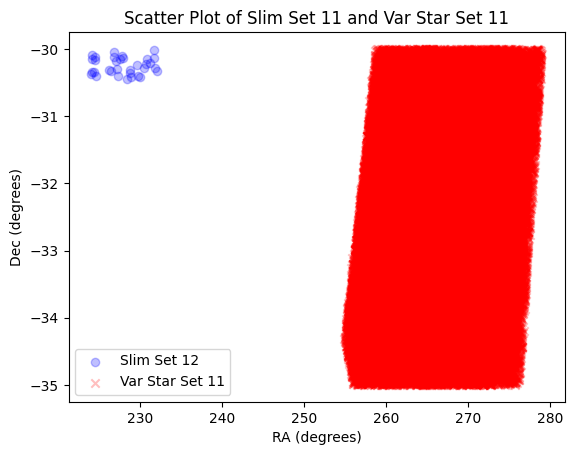

In [28]:
# could run this cell before comparing. allows visualization of data points, albeit on a 2d space
# if so, uncomment the line below and put the number that corresponds to the pair of datasets to compare
# set_num = 

# scatter plot for the 'slim_set{set_num}' dataframe
slim_coords = slim_sets[f'slim_set{set_num}']['Coordinate']
slim_ra = slim_coords.apply(lambda coord: coord.ra.deg)
slim_dec = slim_coords.apply(lambda coord: coord.dec.deg)
plt.scatter(slim_ra, slim_dec, label=f'Slim Set {set_num}', marker='o', color='blue', alpha=0.25)

# scatter plot for the 'var_star_set{set_num}' dataframe
var_coords = var_star_sets[f'var_star_set{set_num}']['Coordinate']
var_ra = var_coords.apply(lambda coord: coord.ra.deg)
var_dec = var_coords.apply(lambda coord: coord.dec.deg)
plt.scatter(var_ra, var_dec, label=f'Var Star Set {set_num}', marker='x', color='red', alpha=0.25)

# labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title(f'Scatter Plot of Slim Set {set_num} and Var Star Set {set_num}')

# legend
plt.legend()

# plot
plt.show()
